In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(823)

params = [0.99, 0.13, 0.8, 0.00066, 0.007] # [beta, kapa, rho, sigma_eps, sigma_eta]
coeffs = [0, 0.4923, 0.6154, 0.115] # [a, b, c, d]
T = 30
N_sims = 500
L_series = 500

In [3]:
def plot_irf(y, labels=None):

    fig, ax = plt.subplots(figsize=(8, 4))
    for i in range(y.shape[0]):
        ax.plot(range(y.shape[1]), y[i, :], label=labels[i], linewidth=2)
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax.set_xlabel("Time after shock (t)")
    ax.set_ylabel("$y_t$")
    ax.set_title("Impulse Response Function of output")
    ax.grid(True)
    ax.legend()

    return fig, ax

In [4]:
def gen_true_imf(coeffs, params, T):

    y = np.zeros(T)
    eps = np.zeros(T)
    eta = np.zeros(T)
    delta_M = np.zeros(T)

    eps[0] = 1.0

    for t in range(T):

        if t == 0:
            y[t] = coeffs[2] * eps[t]
            delta_M[t] = eps[t]

        else:
            y[t] = coeffs[0] * y[t-1] + coeffs[1] * delta_M[t-1] + coeffs[2] * eps[t] + coeffs[3] * eta[t]
            delta_M[t] = params[2] * delta_M[t-1] + eps[t]

    return y

In [5]:
y_true = gen_true_imf(coeffs, params, T)

In [6]:
def sim_data(coeffs, params, N_sims, L_series):

    y = np.zeros((N_sims, L_series))
    delta_M = np.zeros((N_sims, L_series))
    eps = np.random.normal(0, params[3], (N_sims, L_series))
    eta = np.random.normal(0, params[4], (N_sims, L_series))

    for t in range(L_series):

        if t == 0:
            y[:, t] = coeffs[2] * eps[:, t]
            delta_M[:, t] = eps[:, t]

        else:
            y[:, t] = coeffs[0] * y[:, t-1] + coeffs[1] * delta_M[:, t-1] + coeffs[2] * eps[:, t] + coeffs[3] * eta[:, t]
            delta_M[:, t] = params[2] * delta_M[:, t-1] + eps[:, t]

    return y, delta_M, eps, eta

In [7]:
y, delta_M, eps, eta = sim_data(coeffs, params, N_sims, L_series)

In [8]:
def permute_lag_y(y, eps, lag, T):

    irf = np.zeros((y.shape[0], T))

    for i in range(y.shape[0]):

        y_lag = np.zeros((y.shape[1]-lag, lag))
        # create a matrix of lagged y
        for j in range(lag):
            y_lag[:, j] = y[i, lag-j-1:-j-1]

        X = np.column_stack((np.ones(y.shape[1]-lag), y_lag, eps[i, lag:]))
        b = np.linalg.lstsq(X, y[i, lag:], rcond=None)[0]

        irf[i, 0] = b[-1] * 1
        for t in range(1, T):
            cum_sum = 0
            for j in range(1, min(t, lag)+1):
                cum_sum += b[j] * irf[i, t-j]
            irf[i, t] = cum_sum

    return np.median(irf, axis=0)


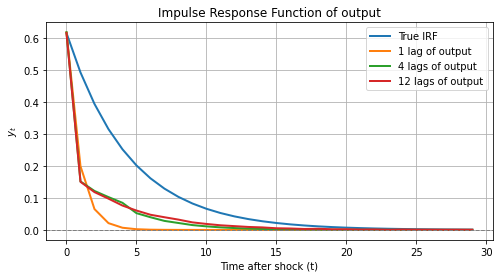

In [9]:
imf_y_1lag = permute_lag_y(y, eps, 1, T)
imf_y_4lag = permute_lag_y(y, eps, 4, T)
imf_y_12lag = permute_lag_y(y, eps, 12, T)

imf_y_lags = np.vstack((y_true, imf_y_1lag, imf_y_4lag, imf_y_12lag))
labels = ["True IRF", "1 lag of output", "4 lags of output", "12 lags of output"]

fig, ax = plot_irf(imf_y_lags, labels)

In [10]:
def permute_lag_eps(y, eps, lag, T):

    irf = np.zeros((y.shape[0], T))
    irf_eps = np.zeros(T)
    irf_eps[0] = 1.0

    for i in range(y.shape[0]):

        eps_lag = np.zeros((eps.shape[1]-lag, lag))
        # create a matrix of lagged epsilon
        for j in range(lag):
            eps_lag[:, j] = eps[i, lag-j-1:-j-1]

        X = np.column_stack((np.ones(y.shape[1]-lag), y[i, lag-1:-1], eps[i, lag:], eps_lag))
        b = np.linalg.lstsq(X, y[i, lag:], rcond=None)[0]

        irf[i, 0] = b[-lag-1] * 1

        for t in range(1, T):
            cum_sum = b[1] * irf[i, t-1]
            for j in range(1, min(t, lag)+1):
                cum_sum += b[j+2] * irf_eps[t-j]
            irf[i, t] = cum_sum

    return np.median(irf, axis=0)

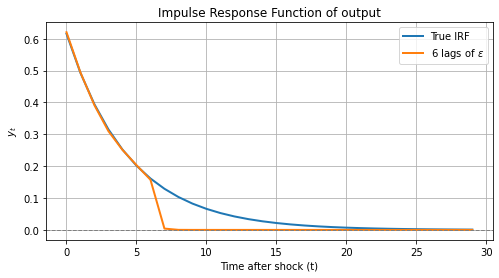

In [11]:
imf_eps_6lag = permute_lag_eps(y, eps, 6, T)

imf_eps_lags = np.vstack((y_true, imf_eps_6lag))
labels = ["True IRF", r"6 lags of $\epsilon$"]

fig, ax = plot_irf(imf_eps_lags, labels)

In [12]:
def irf_lp(y, eps, delta_M, T, controls=False):

    irf = np.zeros((y.shape[0], T))

    for i in range(y.shape[0]):
        for j in range(T):
            # epsilon_t
            if j == 0:
                eps_lp = eps[i, 1:]
            else:
                eps_lp = eps[i, 1:-j]
            # y_{t+j} - y_{t-1}
            y_lp = y[i, j+1:] - y[i, :-j-1]
            assert len(eps_lp) == len(y_lp)

            if controls:
                X_controls = np.column_stack((y[i, :-j-1], delta_M[i, :-j-1]))
                X = np.column_stack((np.ones(len(eps_lp)), eps_lp, X_controls))
            else:
                X = np.column_stack((np.ones(len(eps_lp)), eps_lp))

            b = np.linalg.lstsq(X, y_lp, rcond=None)[0]
            irf[i, j] = b[1]

    return np.median(irf, axis=0)

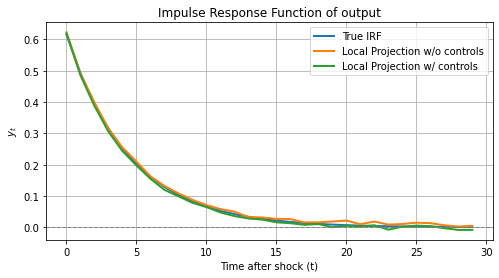

In [13]:
imf_lp_no_control = irf_lp(y, eps, delta_M, T, controls=False)
imf_lp_yes_control = irf_lp(y, eps, delta_M, T, controls=True)

imf_lp = np.vstack((y_true, imf_lp_no_control, imf_lp_yes_control))
labels = ["True IRF", "Local Projection w/o controls", "Local Projection w/ controls"]

fig, ax = plot_irf(imf_lp, labels)